
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online[![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.19?urlpath=lab/tree/api/catalog.ipynb)
- You may download all the notebooks in the documentation as a
[tar file](../../_downloads/notebooks-0.19.tar).
- **Source files:**
[catalog.ipynb](../../_static/notebooks/catalog.ipynb) |
[catalog.py](../../_static/notebooks/catalog.py)
</div>


# Source catalogs

`~gammapy.catalog` provides convenient access to common gamma-ray source catalogs.
This module is mostly independent from the rest of Gammapy.
Typically you use it to compare new analyses against catalog results, e.g. overplot the spectral model, or compare the source position.

Moreover as creating a source model and flux points for a given catalog from the FITS table is tedious, `~gammapy.catalog` has this already implemented. So you can create initial source models for your analyses.
This is very common for Fermi-LAT, to start with a catalog model.
For TeV analysis, especially in crowded Galactic regions, using the HGPS, gamma-cat or 2HWC catalog in this way can also be useful.

In this tutorial you will learn how to:

- List available catalogs
- Load a catalog
- Access the source catalog table data
- Select a catalog subset or a single source
- Get source spectral and spatial models
- Get flux points (if available)
- Get lightcurves (if available)
- Access the source catalog table data
- Pretty-print the source information

In this tutorial we will show examples using the following catalogs:

- `~gammapy.catalog.SourceCatalogHGPS`
- `~gammapy.catalog.SourceCatalogGammaCat`
- `~gammapy.catalog.SourceCatalog3FHL`
- `~gammapy.catalog.SourceCatalog4FGL`

All catalog and source classes work the same, as long as some information is available. E.g. trying to access a lightcurve from a catalog and source that doesn't have that information will return ``None``.

Further information is available at `~gammapy.catalog`.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from gammapy.catalog import CATALOG_REGISTRY

## List available catalogs

`~gammapy.catalog` contains a catalog registry ``CATALOG_REGISTRY``, which maps catalog names (e.g. "3fhl") to catalog classes (e.g. ``SourceCatalog3FHL``). 

In [2]:
CATALOG_REGISTRY

[gammapy.catalog.gammacat.SourceCatalogGammaCat,
 gammapy.catalog.hess.SourceCatalogHGPS,
 gammapy.catalog.hawc.SourceCatalog2HWC,
 gammapy.catalog.fermi.SourceCatalog3FGL,
 gammapy.catalog.fermi.SourceCatalog4FGL,
 gammapy.catalog.fermi.SourceCatalog2FHL,
 gammapy.catalog.fermi.SourceCatalog3FHL,
 gammapy.catalog.hawc.SourceCatalog3HWC]

## Load catalogs

If you have run `gammapy download datasets` or `gammapy download tutorials`,
you have a copy of the catalogs as FITS files in `$GAMMAPY_DATA/catalogs`,
and that is the default location where `~gammapy.catalog` loads from.


In [3]:
!ls -1 $GAMMAPY_DATA/catalogs

2HWC.ecsv
2HWC.yaml
3HWC.ecsv
3HWC.yaml
README.rst
fermi
gammacat
hgps_catalog_v1.fits.gz
make_2hwc.py
make_3hwc.py


In [4]:
!ls -1 $GAMMAPY_DATA/catalogs/fermi

Extended_archive_v15
Extended_archive_v18
LAT_extended_sources_8years
README.rst
gll_psc_v16.fit.gz
gll_psc_v20.fit.gz
gll_psc_v27.fit.gz
gll_psch_v08.fit.gz
gll_psch_v09.fit.gz
gll_psch_v13.fit.gz


So a catalog can be loaded directly from its corresponding class

In [5]:
from gammapy.catalog import SourceCatalog4FGL

catalog = SourceCatalog4FGL()
print("Number of sources :", len(catalog.table))

Number of sources : 5788


Note that it loads the default catalog from `$GAMMAPY_DATA/catalogs`, you could pass a different `filename` when creating the catalog.
For example here we load an older version of 4FGL catalog:  

In [6]:
catalog = SourceCatalog4FGL("$GAMMAPY_DATA/catalogs/fermi/gll_psc_v20.fit.gz")
print("Number of sources :", len(catalog.table))

Number of sources : 5066



Alternatively you can load a catalog by name via `CATALOG_REGISTRY.get_cls(name)()` (note the `()` to instantiate a catalog object from the catalog class - only this will load the catalog and be useful), or by importing the catalog class (e.g. `SourceCatalog3FGL`) directly. The two ways are equivalent, the result will be the same.


In [7]:
# FITS file is loaded
catalog = CATALOG_REGISTRY.get_cls("3fgl")()
catalog

In [8]:
# Let's load the source catalogs we will use throughout this tutorial
catalog_gammacat = CATALOG_REGISTRY.get_cls("gamma-cat")()
catalog_3fhl = CATALOG_REGISTRY.get_cls("3fhl")()
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
catalog_hgps = CATALOG_REGISTRY.get_cls("hgps")()

## Catalog table

Source catalogs are given as `FITS` files that contain one or multiple tables.

However, you can also access the underlying `astropy.table.Table` for a catalog,
and the row data as a Python `dict`. This can be useful if you want to do something
that is not pre-scripted by the `~gammapy.catalog` classes, such as e.g. selecting
sources by sky position or association class, or accessing special source information.


In [9]:
type(catalog_3fhl.table)

astropy.table.table.Table

In [10]:
len(catalog_3fhl.table)

1556

In [11]:
catalog_3fhl.table[:3][["Source_Name", "RAJ2000", "DEJ2000"]]

Source_Name,RAJ2000,DEJ2000
,deg,deg
bytes18,float32,float32
3FHL J0001.2-0748,0.3107,-7.8075
3FHL J0001.9-4155,0.4849,-41.9303
3FHL J0002.1-6728,0.5283,-67.4825


Note that the catalogs object include a helper property that gives directly the sources positions as a `SkyCoord` object (we will show an usage example in the following).

In [12]:
catalog_3fhl.positions[:3]

<SkyCoord (ICRS): (ra, dec) in deg
    [(0.31067517,  -7.8075185), (0.4848653 , -41.93026  ),
     (0.52826166, -67.48248  )]>

## Source object

### Select a source

The catalog entries for a single source are represented by a `SourceCatalogObject`.
In order to select a source object index into the catalog using `[]`, with a catalog table row index (zero-based, first row is `[0]`), or a source name. If a name is given, catalog table columns with source names and association names ("ASSOC1" in the example below) are searched top to bottom. There is no name resolution web query.


In [13]:
source = catalog_4fgl[49]
source

In [14]:
source.row_index, source.name

(49, '4FGL J0010.8-2154')

In [15]:
source = catalog_4fgl["4FGL J0010.8-2154"]
source.row_index, source.name

(49, '4FGL J0010.8-2154')

In [16]:
source.data["ASSOC1"]

'PKS 0008-222                '

In [17]:
source = catalog_4fgl["PKS 0008-222"]
source.row_index, source.name

(49, '4FGL J0010.8-2154')

Note that you can also do a `for source in catalog` loop, to find or process
sources of interest.

###  Source information

The source objects have a `data` property that contains the information of the catalog row corresponding to the source.

In [18]:
source.data["Npred"]

276.04663

In [19]:
source.data["GLON"], source.data["GLAT"]

(<Quantity 60.28118 deg>, <Quantity -79.400505 deg>)

As for the catalog object, the source object has a `position` property.

In [20]:
source.position.galactic

<SkyCoord (Galactic): (l, b) in deg
    (60.28120079, -79.40051035)>

## Select a catalog subset

The catalog objects support selection using boolean arrays (of the same length), so one can create a new catalog as a subset of the main catalog that verify a set of conditions.

In the next example we selection only few of the brightest sources brightest sources in the 100 to 200 GeV energy band.

In [21]:
mask_bright = np.zeros(len(catalog_3fhl.table), dtype=bool)
for k, source in enumerate(catalog_3fhl):
    flux = (
        source.spectral_model()
        .integral(100 * u.GeV, 200 * u.GeV)
        .to("cm-2 s-1")
    )
    if flux > 1e-10 * u.Unit("cm-2 s-1"):
        mask_bright[k] = True
        print(f"{source.row_index:<7d} {source.name:20s} {flux:.3g}")

352     3FHL J0534.5+2201    2.99e-10 1 / (cm2 s)
553     3FHL J0851.9-4620e   1.24e-10 1 / (cm2 s)
654     3FHL J1036.3-5833e   1.57e-10 1 / (cm2 s)
691     3FHL J1104.4+3812    3.34e-10 1 / (cm2 s)
1111    3FHL J1653.8+3945    1.27e-10 1 / (cm2 s)
1219    3FHL J1824.5-1351e   1.77e-10 1 / (cm2 s)
1361    3FHL J2028.6+4110e   1.75e-10 1 / (cm2 s)


In [22]:
catalog_3fhl_bright = catalog_3fhl[mask_bright]
catalog_3fhl_bright

In [23]:
catalog_3fhl_bright.table["Source_Name"]

3FHL J0534.5+2201
3FHL J0851.9-4620e
3FHL J1036.3-5833e
3FHL J1104.4+3812
3FHL J1653.8+3945
3FHL J1824.5-1351e
3FHL J2028.6+4110e


Similarly we can select only sources within a region of interest. Here for example we use the `position` property of the catalog object to select sources whitin 5 degrees from "PKS 0008-222":


In [24]:
source = catalog_4fgl["PKS 0008-222"]
mask_roi = source.position.separation(catalog_4fgl.positions) < 5 * u.deg

In [25]:
catalog_4fgl_roi = catalog_4fgl[mask_roi]
print("Number of sources :", len(catalog_4fgl_roi.table))

Number of sources : 11


## Source models

The `~gammapy.catalog.SourceCatalogObject` classes have a `sky_model()` model
which creates a `gammapy.modeling.models.SkyModel` object, with model parameter
values and parameter errors from the catalog filled in.

In most cases, the `spectral_model()` method provides the `gammapy.modeling.models.SpectralModel`
part of the sky model, and the `spatial_model()` method the `gammapy.modeling.models.SpatialModel`
part individually.

We use the `gammapy.catalog.SourceCatalog3FHL` for the examples in this section.

In [26]:
source = catalog_4fgl["PKS 2155-304"]

In [27]:
model = source.sky_model()
model

SkyModel(spatial_model=<gammapy.modeling.models.spatial.PointSpatialModel object at 0x128724430>, spectral_model=<gammapy.modeling.models.spectral.LogParabolaSpectralModel object at 0x128724940>)temporal_model=None)

In [28]:
print(model)

SkyModel

  Name                      : 4FGL J2158.8-3013
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   1.44e-11   +/- 1.7e-13 1 / (cm2 MeV s)
    reference    (frozen)   :   1118.643       MeV         
    alpha                   :      1.767   +/-    0.01             
    beta                    :      0.041   +/-    0.00             
    lon_0                   :    329.714   +/-    0.00 deg         
    lat_0                   :    -30.225   +/-    0.00 deg         




In [29]:
print(model.spatial_model)

PointSpatialModel

  type   name    value    unit   error      min        max    frozen link
------- ----- ----------- ---- --------- ---------- --------- ------ ----
spatial lon_0  3.2971e+02  deg 3.735e-03        nan       nan  False     
spatial lat_0 -3.0225e+01  deg 3.227e-03 -9.000e+01 9.000e+01  False     


In [30]:
print(model.spectral_model)

LogParabolaSpectralModel

  type      name     value         unit        error   min max frozen link
-------- --------- ---------- -------------- --------- --- --- ------ ----
spectral amplitude 1.4365e-11 cm-2 MeV-1 s-1 1.655e-13 nan nan  False     
spectral reference 1.1186e+03            MeV 0.000e+00 nan nan   True     
spectral     alpha 1.7668e+00                1.163e-02 nan nan  False     
spectral      beta 4.0969e-02                4.120e-03 nan nan  False     


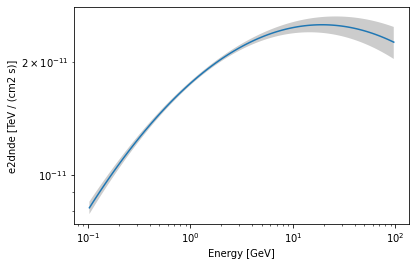

In [31]:
energy_bounds = (100 * u.MeV, 100 * u.GeV)
opts = dict(sed_type="e2dnde", yunits=u.Unit("TeV cm-2 s-1"))
model.spectral_model.plot(energy_bounds, **opts)
model.spectral_model.plot_error(energy_bounds, **opts);

You can create initial source models for your analyses using the `.to_models()` method of the catalog objects. Here for example we create a `Models` object from the 4FGL catalog subset we previously defined:

In [32]:
models_4fgl_roi = catalog_4fgl_roi.to_models()
models_4fgl_roi

## Specificities of the HGPS catalog

Using the `.to_models()` method for the `gammapy.catalog.SourceCatalogHGPS` will return only the models components of the sources retained in the main catalog, several candidate objects appears only in the Gaussian components table (see section 4.9 of the HGPS paper, https://arxiv.org/abs/1804.02432). To access these components you can do the following:


In [33]:
discarded_ind = np.where(
    [
        "Discarded" in _
        for _ in catalog_hgps.table_components["Component_Class"]
    ]
)[0]
discarded_table = catalog_hgps.table_components[discarded_ind]

There is no spectral model available for these components but you can access their spatial models:

In [34]:
discarded_spatial = [
    catalog_hgps.gaussian_component(idx).spatial_model()
    for idx in discarded_ind
]

In addition to the source components the HGPS catalog include a large scale diffuse component built by fitting a gaussian model in a sliding window along the Galactic plane. Information on this model can be accessed via the propoerties `.table_large_scale_component` and `.large_scale_component` of `gammapy.catalog.SourceCatalogHGPS`.

In [35]:
# here we show the 5 first elements of the table
catalog_hgps.table_large_scale_component[:5]
# you can also try :
# help(catalog_hgps.large_scale_component)

GLON,GLAT,GLAT_Err,Surface_Brightness,Surface_Brightness_Err,Width,Width_Err
deg,deg,deg,1 / (cm2 s sr),1 / (cm2 s sr),deg,deg
float32,float32,float32,float32,float32,float32,float32
270.000000,0.205357,0.251932,6.149827e-10,4.064108e-10,0.269385,0.137990
272.959198,-0.120154,0.058201,1.426735e-09,7.346488e-10,0.088742,0.041882
275.918365,-0.095232,0.089881,1.193710e-09,6.117877e-10,0.167219,0.111797
278.877563,-0.257642,0.065071,1.506986e-09,5.230542e-10,0.156525,0.056130
281.836731,-0.283487,0.066442,1.636973e-09,4.336444e-10,0.205192,0.049676


## Flux points

The flux points are available via the `flux_points` property as a `gammapy.spectrum.FluxPoints` object.

In [36]:
source = catalog_4fgl["PKS 2155-304"]
flux_points = source.flux_points

In [37]:
flux_points

In [38]:
flux_points.to_table(sed_type="flux")

e_ref,e_min,e_max,flux,flux_errp,flux_errn,flux_ul,sqrt_ts,is_ul
MeV,MeV,MeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,
float64,float64,float64,float64,float64,float64,float64,float32,bool
70.71067811865478,49.99999999999999,100.00000000000004,8.811208118686409e-08,3.097255785178277e-08,3.039940565940924e-08,nan,2.5337915,False
173.20508075688775,100.00000000000004,299.99999999999994,6.859372092549165e-08,3.0207172319052233e-09,3.0207172319052233e-09,nan,25.057798,False
547.722557505166,299.99999999999994,999.9999999999998,3.348723609519766e-08,6.225928661507396e-10,6.225928661507396e-10,nan,88.745026,False
1732.0508075688763,999.9999999999998,2999.9999999999977,1.274911376469845e-08,2.198041054723987e-10,2.198041054723987e-10,nan,128.2931,False
5477.225575051666,2999.9999999999977,10000.00000000001,5.410327741373067e-09,1.2490801448716837e-10,1.2490801448716837e-10,nan,120.772316,False
17320.50807568877,10000.00000000001,30000.000000000007,1.7687512565700558e-09,6.802798602212334e-11,6.802798602212334e-11,nan,82.056656,False
94868.32980505146,30000.000000000007,299999.9999999999,6.965684695714458e-10,4.1411239021238444e-11,4.1411239021238444e-11,nan,54.02705,False


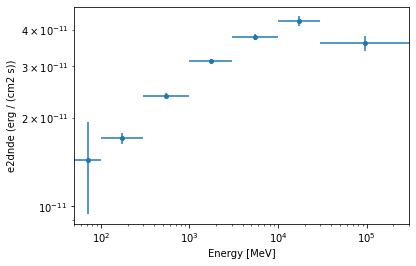

In [39]:
flux_points.plot(sed_type="e2dnde");

## Lightcurves

The Fermi catalogs contain lightcurves for each source. It is available via the `source.lightcurve()` method as a `~gammapy.estimators.LightCurve` object.

In [40]:
lightcurve = catalog_4fgl["4FGL J0349.8-2103"].lightcurve()

In [41]:
lightcurve

In [42]:
lightcurve.to_table(format="lightcurve", sed_type="flux")

time_min,time_max,e_ref [1],e_min [1],e_max [1],flux [1],flux_errp [1],flux_errn [1],flux_ul [1],ts [1],sqrt_ts [1],is_ul [1]
,,MeV,MeV,MeV,1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),1 / (cm2 s),,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,bool
54682.65603794185,55045.301668796295,3872.9833462074166,49.99999999999999,299999.9999999999,8.182966837466665e-08,4.0442960091979785e-09,4.0442960091979785e-09,8.991825950488419e-08,866.5454,29.437143,False
55045.301668796295,55410.57944657407,3872.9833462074166,49.99999999999999,299999.9999999999,3.4780882174345606e-08,3.377941926174799e-09,3.377941926174799e-09,4.1536765138516785e-08,177.31786,13.316075,False
55410.57944657407,55775.85722435185,3872.9833462074166,49.99999999999999,299999.9999999999,1.4417943283717705e-08,2.6934492414198985e-09,2.530577081216734e-09,1.980484221064671e-08,45.33303,6.7329807,False
55775.85722435185,56141.13500212963,3872.9833462074166,49.99999999999999,299999.9999999999,1.8312720229118895e-08,2.9073525809053535e-09,2.697997159017973e-09,2.4127425390929602e-08,69.82312,8.356023,False
56141.13500212963,56506.412779907405,3872.9833462074166,49.99999999999999,299999.9999999999,1.929730331085011e-08,3.0470421741313203e-09,2.900109263848094e-09,2.5391386770934332e-08,63.285576,7.955223,False
56506.412779907405,56871.690557685186,3872.9833462074166,49.99999999999999,299999.9999999999,2.279863409171412e-08,3.0816984519788093e-09,2.9492861486346555e-09,2.896203099567174e-08,98.43889,9.921638,False
56871.690557685186,57236.96833546296,3872.9833462074166,49.99999999999999,299999.9999999999,3.4101141466180707e-08,3.5666940512157908e-09,3.438366702468443e-09,4.123452868043387e-08,164.55066,12.82773,False
57236.96833546296,57602.24611324074,3872.9833462074166,49.99999999999999,299999.9999999999,1.2460412257553344e-08,2.889906092207184e-09,2.7565447702215806e-09,1.824022533014613e-08,26.10482,5.1092877,False


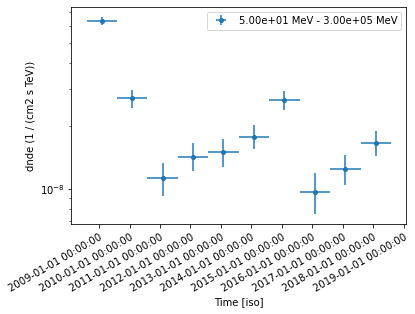

In [43]:
lightcurve.plot();

## Pretty-print source information

A source object has a nice string representation that you can print.


In [44]:
source = catalog_hgps["MSH 15-52"]
print(source)


*** Basic info ***

Catalog row index (zero-based) : 18
Source name          : HESS J1514-591
Analysis reference   : HGPS
Source class         : PWN
Identified object    : MSH 15-52
Gamma-Cat id         : 79


*** Info from map analysis ***

RA                   :  228.499 deg = 15h14m00s
DEC                  :  -59.161 deg = -59d09m41s
GLON                 :  320.315 +/- 0.008 deg
GLAT                 :   -1.188 +/- 0.007 deg
Position Error (68%) : 0.020 deg
Position Error (95%) : 0.033 deg
ROI number           : 13
Spatial model        : 3-Gaussian
Spatial components   : HGPSC 023, HGPSC 024, HGPSC 025
TS                   : 1763.4
sqrt(TS)             : 42.0
Size                 : 0.145 +/- 0.026 (UL: 0.000) deg
R70                  : 0.215 deg
RSpec                : 0.215 deg
Total model excess   : 3502.8
Excess in RSpec      : 2440.5
Model Excess in RSpec : 2414.3
Background in RSpec  : 1052.5
Livetime             : 41.4 hours
Energy threshold     : 0.61 TeV
Source flux (>1 TeV) 

You can also call `source.info()` instead and pass as an option what information to print. The options available depend on the catalog, you can learn about them using `help()`

In [45]:
help(source.info)

Help on method info in module gammapy.catalog.hess:

info(info='all') method of gammapy.catalog.hess.SourceCatalogObjectHGPS instance
    Info string.
    
    Parameters
    ----------
    info : {'all', 'basic', 'map', 'spec', 'flux_points', 'components', 'associations', 'id'}
        Comma separated list of options



In [46]:
print(source.info("associations"))


*** Source associations info ***

  Source_Name    Association_Catalog    Association_Name   Separation
                                                              deg    
---------------- ------------------- --------------------- ----------
  HESS J1514-591                2FHL    2FHL J1514.0-5915e   0.098903
  HESS J1514-591                3FGL     3FGL J1513.9-5908   0.026914
  HESS J1514-591                3FGL    3FGL J1514.0-5915e   0.094834
  HESS J1514-591                COMP            G320.4-1.2   0.070483
  HESS J1514-591                 PSR              B1509-58   0.026891

